### Paper 11-27-22

https://github.com/cnaimo/hybrid-ARIMA-LSTM-model

In [1]:
# import 

import pandas as pd
import numpy as np
from scipy.stats import kurtosis, pearsonr
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from talib import abstract
import statistics
import json

In [2]:
def mean_absolute_percentage_error(actual, prediction):
    actual = pd.Series(actual)
    prediction = pd.Series(prediction)
    return 100 * np.mean(np.abs((actual - prediction))/actual)

In [3]:
def get_arima(data, train_len, test_len):
    # prepare train and test data
    data = data.tail(test_len + train_len).reset_index(drop=True)
    train = data.head(train_len).values.tolist()
    test = data.tail(test_len).values.tolist()

    # Initialize model
    model = auto_arima(train, max_p=3, max_q=3, seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

    # Determine model parameters
    model.fit(train)
    order = model.get_params()['order']
    print('ARIMA order:', order, '\n')

    # Genereate predictions
    global model_arima
    prediction = []
    for i in range(len(test)):
        model_arima = pm.ARIMA(order=order)
        model_arima.fit(train)
        print('working on', i+1, 'of', test_len, '-- ' + str(int(100 * (i + 1) / test_len)) + '% complete')
        prediction.append(model_arima.predict()[0])
        train.append(test[i])

    # Generate error data
    mse = mean_squared_error(test, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(pd.Series(test), pd.Series(prediction))
    return prediction, mse, rmse, mape



In [4]:
def get_lstm(data, train_len, test_len, lstm_len=4):
    # prepare train and test data
    data = data.tail(test_len + train_len).reset_index(drop=True)
    dataset = np.reshape(data.values, (len(data), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)   # fitting all data from 0-1
    x_train = []
    y_train = []
    x_test = []

    for i in range(lstm_len, train_len):
        x_train.append(dataset_scaled[i - lstm_len:i, 0])
        y_train.append(dataset_scaled[i, 0])
    for i in range(train_len, len(dataset_scaled)):
        x_test.append(dataset_scaled[i - lstm_len:i, 0])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Set up & fit LSTM RNN
    global model_lstm
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=lstm_len, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model_lstm.add(LSTM(units=int(lstm_len/2)))
    model_lstm.add(Dense(1, activation='sigmoid'))

    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    model_lstm.fit(x_train, y_train, epochs=500, batch_size=1, verbose=2, callbacks=[early_stopping])

    # Generate predictions
    prediction = model_lstm.predict(x_test)
    prediction = scaler.inverse_transform(prediction).tolist()

    output = []
    for i in range(len(prediction)):
        output.extend(prediction[i])
    prediction = output

    # Generate error data
    mse = mean_squared_error(data.tail(len(prediction)).values, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data.tail(len(prediction)).reset_index(drop=True), pd.Series(prediction))
    return prediction, mse, rmse, mape


In [5]:
data_file = 'C:/Users/Mya_L/Documents/JupyterLab_projects/Suplemnter/Data_for_paper-11-27-22/Data-00b.csv'
data = pd.read_csv(data_file, index_col=0, header=0).tail(1500).reset_index(drop=True)

In [6]:
data.describe()

,MAX Temperature,MIN Temperature_C,Relative Humidity M,Relative Humidity E
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,26.180533,10.416933,87.527333,47.178000
std,7.031699,5.407070,13.641602,18.371191
min,8.900000,-0.300000,23.000000,11.000000
25%,21.400000,6.200000,83.000000,34.000000
50%,25.900000,10.000000,92.000000,45.000000
75%,30.400000,14.500000,98.000000,58.000000
max,44.000000,28.900000,100.000000,100.000000


In [7]:
data.columns

Index(['MAX Temperature', 'MIN Temperature_C ', 'Relative Humidity M',
       'Relative Humidity E', 'Bright Sun Shine Hours'],
      dtype='object')

In [8]:
data['close'] = data['MAX Temperature'] 
data = data.drop(['MAX Temperature', 'MIN Temperature_C ', 'Relative Humidity M', 'Relative Humidity E', 'Bright Sun Shine Hours'], axis= 1)
data

,close
0,24.7
1,22.9
2,23.4
3,26.0
4,27.9
...,...
1495,40.0
1496,40.4
1497,41.4
1498,43.4


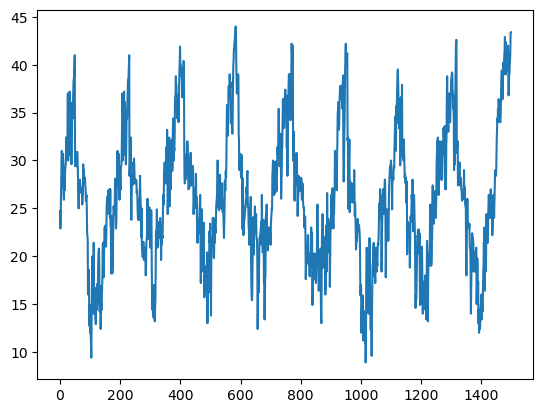

In [9]:
import matplotlib.pyplot as plt

# Select the column to use as the y-coordinates
y = data['close']

# Draw the data points
plt.plot(y)

# Show the plot
plt.show()

In [10]:
# to do 12-12-22
# 1- see ifyou figure git commit
# 2- fix close, to work on any datqw35
# 3- git rid of unwanted columnw any thing but close and date
# 4- understand code  (low priooity)

In [11]:



if __name__ == '__main__':
    # Load historical data
    # CSV should have columns: ['date', 'open', 'high', 'low', 'close', 'volume']
    # data_file = 'C:/Users/Mya_L/Documents/JupyterLab_projects/Suplemnter/Data_for_paper-11-27-22/all_stocks_5yr_a.csv'
    # data = pd.read_csv(data_file, index_col=0, header=0).tail(1500).reset_index(drop=True)


    TargetPrediction = 'close'
    # Initialize moving averages from Ta-Lib, store functions in dictionary
    # We got rid of 'MIDPRICE'due to high low 
    talib_moving_averages = ['SMA', 'EMA', 'WMA', 'DEMA', 'KAMA', 'MIDPOINT', 'T3', 'TEMA', 'TRIMA']
    functions = {}
    for ma in talib_moving_averages:
        functions[ma] = abstract.Function(ma)

    # Determine kurtosis "K" values for MA period 4-99
    kurtosis_results = {'period': []}
    for i in range(4, 100):
        kurtosis_results['period'].append(i)
        for ma in talib_moving_averages:
            # Run moving average, remove last 252 days (used later for test data set), trim MA result to last 60 days
            ma_output = functions[ma](data[:-252], i).tail(60)

            # Determine kurtosis "K" value
            k = kurtosis(ma_output, fisher=False)

            # add to dictionary
            if ma not in kurtosis_results.keys():
                kurtosis_results[ma] = []
            kurtosis_results[ma].append(k)

    kurtosis_results = pd.DataFrame(kurtosis_results)
    kurtosis_results.to_csv('kurtosis_results.csv')

    # Determine period with K closest to 3 +/-5%
    optimized_period = {}
    for ma in talib_moving_averages:
        difference = np.abs(kurtosis_results[ma] - 3)
        df = pd.DataFrame({'difference': difference, 'period': kurtosis_results['period']})
        df = df.sort_values(by=['difference'], ascending=True).reset_index(drop=True)
        if df.at[0, 'difference'] < 3 * 0.05:
            optimized_period[ma] = df.at[0, 'period']
        else:
            print(ma + ' is not viable, best K greater or less than 3 +/-5%')

    print('\nOptimized periods:', optimized_period)

    simulation = {}
    for ma in optimized_period:
        # Split data into low volatility and high volatility time series
        low_vol = functions[ma](data, int(optimized_period[ma]))
        high_vol = data[TargetPrediction] - low_vol

        # Generate ARIMA and LSTM predictions
        print('\nWorking on ' + ma + ' predictions')
        try:
            low_vol_prediction, low_vol_mse, low_vol_rmse, low_vol_mape = get_arima(low_vol, 1000, 252)
        except:
            print('ARIMA error, skipping to next MA type')
            continue

        high_vol_prediction, high_vol_mse, high_vol_rmse, high_vol_mape = get_lstm(high_vol, 1000, 252)

        final_prediction = pd.Series(low_vol_prediction) + pd.Series(high_vol_prediction)
        mse = mean_squared_error(data[TargetPrediction].tail(252).values, final_prediction.values)

        #  Mean Absolute Error
        mae = mean_absolute_error(data[TargetPrediction].tail(252).values, final_prediction.values)
        # print('Train Score: %.2f MAE' % (mae))

        #  Coefficient of Determination-R2 score
        cod_r2 = r2_score(data[TargetPrediction].tail(252).values, final_prediction.values)
        # print('Train Score: %.2f r2' % (trainScore_r2))

        # RRMSE relative root mean square error (RRMSE) is calculated by dividing the RMSE by the mean observed data 
        rmse = mse ** 0.5
        rrmse = rmse/statistics.mean(data[TargetPrediction].tail(252).values)
        # print('Train Score: %.2f RRMSE' % (RRMSE_train))

        # calculate Pearson's correlation
        p_correlation = pearsonr(data[TargetPrediction].tail(252).values, final_prediction.values)
        # print('Train Score: %.2f correlation ' % (trainScore_correlation[0]))

        # calculate Mean Bias Error(MBE) for a set of actual and test prediction
        mbe = np.mean(final_prediction.values - data[TargetPrediction].tail(252).values) #here we calculate MBE
        # print('Train Score: %.2f Mean Bias Error ' % (MBE_train))
    
        
        mape = mean_absolute_percentage_error(data[TargetPrediction].tail(252).reset_index(drop=True), final_prediction)

        # Generate prediction accuracy
        actual = data[TargetPrediction].tail(252).values
        result_1 = []
        result_2 = []
        for i in range(1, len(final_prediction)):
            # Compare prediction to previous close price
            if final_prediction[i] > actual[i-1] and actual[i] > actual[i-1]:
                result_1.append(1)
            elif final_prediction[i] < actual[i-1] and actual[i] < actual[i-1]:
                result_1.append(1)
            else:
                result_1.append(0)

            # Compare prediction to previous prediction
            if final_prediction[i] > final_prediction[i-1] and actual[i] > actual[i-1]:
                result_2.append(1)
            elif final_prediction[i] < final_prediction[i-1] and actual[i] < actual[i-1]:
                result_2.append(1)
            else:
                result_2.append(0)

        accuracy_1 = np.mean(result_1)
        accuracy_2 = np.mean(result_2)

        simulation[ma] = {'low_vol': {'prediction': low_vol_prediction, 'mse': low_vol_mse,
                                      'rmse': low_vol_rmse, 'mape': low_vol_mape},
                          'high_vol': {'prediction': high_vol_prediction, 'mse': high_vol_mse,
                                       'rmse': high_vol_rmse},
                          'final': {'prediction': final_prediction.values.tolist(), 'mse': mse,
                                    'mae':mae ,'cod_r2':cod_r2,'rmse': rmse,'rrmse':rrmse, 
                                     'p_correlation': p_correlation ,'mbe':mbe,'mape': mape},
                          'accuracy': {'prediction vs close': accuracy_1, 'prediction vs prediction': accuracy_2}}

        # save simulation data here as checkpoint
        with open('simulation_data.json', 'w') as fp:
            json.dump(simulation, fp)

    for ma in simulation.keys():
        print('\n' + ma)
        print('Prediction vs Close:\t\t' + str(round(100*simulation[ma]['accuracy']['prediction vs close'], 2))
              + '% Accuracy')
        print('Prediction vs Prediction:\t' + str(round(100*simulation[ma]['accuracy']['prediction vs prediction'], 2))
              + '% Accuracy')
        print('MSE:\t', simulation[ma]['final']['mse'],
              '\nMAE:\t', simulation[ma]['final']['mae'],
              '\nCoefficient of Determination-R2:\t', simulation[ma]['final']['cod_r2'],
              '\nRMSE:\t', simulation[ma]['final']['rmse'],
              '\nRRMSE:\t', simulation[ma]['final']['rrmse'],
              '\nPearsons correlation:\t', simulation[ma]['final']['p_correlation'],
              '\nMBE:\t', simulation[ma]['final']['mbe'],
              '\nMAPE:\t', simulation[ma]['final']['mape'])

SMA is not viable, best K greater or less than 3 +/-5%
EMA is not viable, best K greater or less than 3 +/-5%
WMA is not viable, best K greater or less than 3 +/-5%
DEMA is not viable, best K greater or less than 3 +/-5%
T3 is not viable, best K greater or less than 3 +/-5%
TEMA is not viable, best K greater or less than 3 +/-5%
TRIMA is not viable, best K greater or less than 3 +/-5%

Optimized periods: {'KAMA': 25, 'MIDPOINT': 21}

Working on KAMA predictions
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1174.708, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.859, Time=1.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1141.294, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-643.513, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.880, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1176.102, Time=2.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-842.174, Time=1.57 sec
 ARIMA(1,1,1)(0,0,0)[0] inte

C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


working on 44 of 252 -- 17% complete
working on 45 of 252 -- 17% complete
working on 46 of 252 -- 18% complete
working on 47 of 252 -- 18% complete
working on 48 of 252 -- 19% complete
working on 49 of 252 -- 19% complete
working on 50 of 252 -- 19% complete
working on 51 of 252 -- 20% complete
working on 52 of 252 -- 20% complete
working on 53 of 252 -- 21% complete
working on 54 of 252 -- 21% complete
working on 55 of 252 -- 21% complete
working on 56 of 252 -- 22% complete
working on 57 of 252 -- 22% complete
working on 58 of 252 -- 23% complete
working on 59 of 252 -- 23% complete
working on 60 of 252 -- 23% complete
working on 61 of 252 -- 24% complete
working on 62 of 252 -- 24% complete
working on 63 of 252 -- 25% complete
working on 64 of 252 -- 25% complete
working on 65 of 252 -- 25% complete
working on 66 of 252 -- 26% complete
working on 67 of 252 -- 26% complete
working on 68 of 252 -- 26% complete
working on 69 of 252 -- 27% complete
working on 70 of 252 -- 27% complete
w

C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


working on 99 of 252 -- 39% complete
working on 100 of 252 -- 39% complete
working on 101 of 252 -- 40% complete
working on 102 of 252 -- 40% complete
working on 103 of 252 -- 40% complete
working on 104 of 252 -- 41% complete
working on 105 of 252 -- 41% complete
working on 106 of 252 -- 42% complete
working on 107 of 252 -- 42% complete
working on 108 of 252 -- 42% complete
working on 109 of 252 -- 43% complete
working on 110 of 252 -- 43% complete
working on 111 of 252 -- 44% complete
working on 112 of 252 -- 44% complete
working on 113 of 252 -- 44% complete
working on 114 of 252 -- 45% complete
working on 115 of 252 -- 45% complete
working on 116 of 252 -- 46% complete
working on 117 of 252 -- 46% complete
working on 118 of 252 -- 46% complete
working on 119 of 252 -- 47% complete
working on 120 of 252 -- 47% complete
working on 121 of 252 -- 48% complete
working on 122 of 252 -- 48% complete
working on 123 of 252 -- 48% complete
working on 124 of 252 -- 49% complete
working on 12

C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


working on 173 of 252 -- 68% complete
working on 174 of 252 -- 69% complete
working on 175 of 252 -- 69% complete
working on 176 of 252 -- 69% complete
working on 177 of 252 -- 70% complete
working on 178 of 252 -- 70% complete
working on 179 of 252 -- 71% complete
working on 180 of 252 -- 71% complete
working on 181 of 252 -- 71% complete
working on 182 of 252 -- 72% complete
working on 183 of 252 -- 72% complete
working on 184 of 252 -- 73% complete
working on 185 of 252 -- 73% complete
working on 186 of 252 -- 73% complete
working on 187 of 252 -- 74% complete
working on 188 of 252 -- 74% complete
working on 189 of 252 -- 75% complete
working on 190 of 252 -- 75% complete
working on 191 of 252 -- 75% complete
working on 192 of 252 -- 76% complete
working on 193 of 252 -- 76% complete
working on 194 of 252 -- 76% complete
working on 195 of 252 -- 77% complete
working on 196 of 252 -- 77% complete
working on 197 of 252 -- 78% complete
working on 198 of 252 -- 78% complete
working on 1

C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 1 of 252 -- 0% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 2 of 252 -- 0% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 3 of 252 -- 1% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 4 of 252 -- 1% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 5 of 252 -- 1% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 6 of 252 -- 2% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 7 of 252 -- 2% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 8 of 252 -- 3% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 9 of 252 -- 3% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 10 of 252 -- 3% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 11 of 252 -- 4% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 12 of 252 -- 4% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 13 of 252 -- 5% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 14 of 252 -- 5% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 15 of 252 -- 5% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 16 of 252 -- 6% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 17 of 252 -- 6% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 18 of 252 -- 7% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 19 of 252 -- 7% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 20 of 252 -- 7% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 21 of 252 -- 8% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 22 of 252 -- 8% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 23 of 252 -- 9% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 24 of 252 -- 9% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 25 of 252 -- 9% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 26 of 252 -- 10% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 27 of 252 -- 10% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta

working on 28 of 252 -- 11% complete
working on 29 of 252 -- 11% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 30 of 252 -- 11% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 31 of 252 -- 12% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 32 of 252 -- 12% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 33 of 252 -- 13% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 34 of 252 -- 13% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 35 of 252 -- 13% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 36 of 252 -- 14% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 37 of 252 -- 14% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 38 of 252 -- 15% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 39 of 252 -- 15% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 40 of 252 -- 15% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 41 of 252 -- 16% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 42 of 252 -- 16% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 43 of 252 -- 17% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 44 of 252 -- 17% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 45 of 252 -- 17% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 46 of 252 -- 18% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 47 of 252 -- 18% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 48 of 252 -- 19% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 49 of 252 -- 19% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 50 of 252 -- 19% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 51 of 252 -- 20% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 52 of 252 -- 20% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 53 of 252 -- 21% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 54 of 252 -- 21% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 55 of 252 -- 21% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 56 of 252 -- 22% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 57 of 252 -- 22% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 58 of 252 -- 23% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta

working on 59 of 252 -- 23% complete
working on 60 of 252 -- 23% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 61 of 252 -- 24% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 62 of 252 -- 24% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 63 of 252 -- 25% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 64 of 252 -- 25% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 65 of 252 -- 25% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 66 of 252 -- 26% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 67 of 252 -- 26% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 68 of 252 -- 26% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 69 of 252 -- 27% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 70 of 252 -- 27% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 71 of 252 -- 28% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 72 of 252 -- 28% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 73 of 252 -- 28% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 74 of 252 -- 29% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 75 of 252 -- 29% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 76 of 252 -- 30% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 77 of 252 -- 30% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 78 of 252 -- 30% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 79 of 252 -- 31% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 80 of 252 -- 31% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 81 of 252 -- 32% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 82 of 252 -- 32% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 83 of 252 -- 32% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 84 of 252 -- 33% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 85 of 252 -- 33% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 86 of 252 -- 34% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 87 of 252 -- 34% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 88 of 252 -- 34% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 89 of 252 -- 35% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 90 of 252 -- 35% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 91 of 252 -- 36% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 92 of 252 -- 36% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 93 of 252 -- 36% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 94 of 252 -- 37% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 95 of 252 -- 37% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 96 of 252 -- 38% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 97 of 252 -- 38% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 98 of 252 -- 38% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 99 of 252 -- 39% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 100 of 252 -- 39% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 101 of 252 -- 40% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 102 of 252 -- 40% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 103 of 252 -- 40% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 104 of 252 -- 41% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


working on 105 of 252 -- 41% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 106 of 252 -- 42% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 107 of 252 -- 42% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


working on 108 of 252 -- 42% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 109 of 252 -- 43% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 110 of 252 -- 43% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 111 of 252 -- 44% complete
working on 112 of 252 -- 44% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 113 of 252 -- 44% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 114 of 252 -- 45% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 115 of 252 -- 45% complete
working on 116 of 252 -- 46% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 117 of 252 -- 46% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 118 of 252 -- 46% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 119 of 252 -- 47% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 120 of 252 -- 47% complete
working on 121 of 252 -- 48% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 122 of 252 -- 48% complete
working on 123 of 252 -- 48% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 124 of 252 -- 49% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 125 of 252 -- 49% complete
working on 126 of 252 -- 50% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 127 of 252 -- 50% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 128 of 252 -- 50% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 129 of 252 -- 51% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 130 of 252 -- 51% complete
working on 131 of 252 -- 51% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 132 of 252 -- 52% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 133 of 252 -- 52% complete
working on 134 of 252 -- 53% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 135 of 252 -- 53% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 136 of 252 -- 53% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 137 of 252 -- 54% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 138 of 252 -- 54% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


working on 139 of 252 -- 55% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 140 of 252 -- 55% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 141 of 252 -- 55% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 142 of 252 -- 56% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 143 of 252 -- 56% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 144 of 252 -- 57% complete
working on 145 of 252 -- 57% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 146 of 252 -- 57% complete
working on 147 of 252 -- 58% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 148 of 252 -- 58% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 149 of 252 -- 59% complete
working on 150 of 252 -- 59% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 151 of 252 -- 59% complete
working on 152 of 252 -- 60% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 153 of 252 -- 60% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 154 of 252 -- 61% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 155 of 252 -- 61% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 156 of 252 -- 61% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 157 of 252 -- 62% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 158 of 252 -- 62% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 159 of 252 -- 63% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 160 of 252 -- 63% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 161 of 252 -- 63% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 162 of 252 -- 64% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 163 of 252 -- 64% complete
working on 164 of 252 -- 65% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 165 of 252 -- 65% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 166 of 252 -- 65% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 167 of 252 -- 66% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 168 of 252 -- 66% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 169 of 252 -- 67% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 170 of 252 -- 67% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 171 of 252 -- 67% complete
working on 172 of 252 -- 68% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 173 of 252 -- 68% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 174 of 252 -- 69% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 175 of 252 -- 69% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 176 of 252 -- 69% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 177 of 252 -- 70% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 178 of 252 -- 70% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 179 of 252 -- 71% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 180 of 252 -- 71% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 181 of 252 -- 71% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 182 of 252 -- 72% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 183 of 252 -- 72% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 184 of 252 -- 73% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 185 of 252 -- 73% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 186 of 252 -- 73% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 187 of 252 -- 74% complete
working on 188 of 252 -- 74% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 189 of 252 -- 75% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 190 of 252 -- 75% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 191 of 252 -- 75% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 192 of 252 -- 76% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 193 of 252 -- 76% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 194 of 252 -- 76% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 195 of 252 -- 77% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 196 of 252 -- 77% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 197 of 252 -- 78% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 198 of 252 -- 78% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 199 of 252 -- 78% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 200 of 252 -- 79% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 201 of 252 -- 79% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 202 of 252 -- 80% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 203 of 252 -- 80% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 204 of 252 -- 80% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 205 of 252 -- 81% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 206 of 252 -- 81% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


working on 207 of 252 -- 82% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 208 of 252 -- 82% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 209 of 252 -- 82% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 210 of 252 -- 83% complete
working on 211 of 252 -- 83% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 212 of 252 -- 84% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 213 of 252 -- 84% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 214 of 252 -- 84% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 215 of 252 -- 85% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 216 of 252 -- 85% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 217 of 252 -- 86% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 218 of 252 -- 86% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 219 of 252 -- 86% complete
working on 220 of 252 -- 87% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 221 of 252 -- 87% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 222 of 252 -- 88% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 223 of 252 -- 88% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 224 of 252 -- 88% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 225 of 252 -- 89% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 226 of 252 -- 89% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 227 of 252 -- 90% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 228 of 252 -- 90% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 229 of 252 -- 90% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 230 of 252 -- 91% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 231 of 252 -- 91% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 232 of 252 -- 92% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 233 of 252 -- 92% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 234 of 252 -- 92% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 235 of 252 -- 93% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 236 of 252 -- 93% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 237 of 252 -- 94% complete
working on 238 of 252 -- 94% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 239 of 252 -- 94% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 240 of 252 -- 95% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 241 of 252 -- 95% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 242 of 252 -- 96% complete
working on 243 of 252 -- 96% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 244 of 252 -- 96% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 245 of 252 -- 97% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 246 of 252 -- 97% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 247 of 252 -- 98% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 248 of 252 -- 98% complete
working on 249 of 252 -- 98% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 250 of 252 -- 99% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 251 of 252 -- 99% complete


C:\Users\Mya_L\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


working on 252 of 252 -- 100% complete
Epoch 1/500
996/996 - 20s - loss: 0.0347 - 20s/epoch - 20ms/step
Epoch 2/500
996/996 - 6s - loss: 0.0259 - 6s/epoch - 6ms/step
Epoch 3/500
996/996 - 6s - loss: 0.0249 - 6s/epoch - 6ms/step
Epoch 4/500
996/996 - 5s - loss: 0.0239 - 5s/epoch - 5ms/step
Epoch 5/500
996/996 - 4s - loss: 0.0234 - 4s/epoch - 4ms/step
Epoch 6/500
996/996 - 5s - loss: 0.0224 - 5s/epoch - 5ms/step
Epoch 7/500
996/996 - 4s - loss: 0.0210 - 4s/epoch - 4ms/step
Epoch 8/500
996/996 - 4s - loss: 0.0195 - 4s/epoch - 4ms/step
Epoch 9/500
996/996 - 4s - loss: 0.0175 - 4s/epoch - 4ms/step
Epoch 10/500
996/996 - 5s - loss: 0.0161 - 5s/epoch - 5ms/step
Epoch 11/500
996/996 - 5s - loss: 0.0149 - 5s/epoch - 5ms/step
Epoch 12/500
996/996 - 10s - loss: 0.0141 - 10s/epoch - 10ms/step
Epoch 13/500
996/996 - 6s - loss: 0.0137 - 6s/epoch - 6ms/step
Epoch 14/500
996/996 - 6s - loss: 0.0135 - 6s/epoch - 6ms/step
Epoch 15/500
996/996 - 5s - loss: 0.0137 - 5s/epoch - 5ms/step
Epoch 16/500
996/99

In [12]:
for ma in optimized_period:
    # Split data into low volatility and high volatility time series
    low_vol = functions[ma](data, int(optimized_period[ma]))
    high_vol = data['close'] - low_vol

In [13]:
# model_arima.predict()

test_len = 252
test_arimaForcast = low_vol.tail(test_len).values.tolist()

forcast_arima = []
for i in range(14):
    model_arima.fit(test_arimaForcast)
    forcasted_value = "{:.2f}".format(model_arima.predict()[0])
    forcast_arima.append(forcasted_value)
    # forcast.append(forcasted_value) # use with data.tail
    test_arimaForcast.append(forcasted_value)

print(forcast_arima)

['40.22', '40.35', '40.48', '40.61', '40.74', '40.87', '41.00', '41.12', '41.24', '41.36', '41.48', '41.60', '41.72', '41.84']


In [14]:
# test_arimaForcast = data.tail(6).values.tolist()
# test_arimaForcast= test_arimaForcast[:-1]
# test_arimaForcast.append(forca)



In [15]:
lstm_len1 = 4
train_len1 = 1000
test_len1 = 252
 
data_lstm = high_vol.tail(test_len1 + train_len1).reset_index(drop=True)
data_lstm = np.reshape(data_lstm.values, (len(data_lstm), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(data_lstm)   # fitting all data from 0-1
x_train = []
y_train = []
x_test = []

for i in range(lstm_len1, train_len1):
    x_train.append(dataset_scaled[i - lstm_len1:i, 0])
    y_train.append(dataset_scaled[i, 0])
for i in range(train_len1, len(dataset_scaled)):
    x_test.append(dataset_scaled[i - lstm_len1:i, 0])


# note: x_test[0] is newst while x_teest[last] oldest
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
forcast_lstm = []
for i in range(14):
    lstm_predict = model_lstm.predict(x_test)[0]
    x_test = np.delete(x_test, len(x_test)-1, 0) # remove oldest data
    focasted_ar = np.copy(x_test[0])
    focasted_ar[0] = focasted_ar[1]
    focasted_ar[1] = focasted_ar[2]
    focasted_ar[2] = focasted_ar[3]
    focasted_ar[3] = lstm_predict
    x_test = np.insert(x_test, 0 , [focasted_ar] ,axis = 0) # insert in begning
    forcast_lstm.append(lstm_predict)

forcast_lstm = scaler.inverse_transform(forcast_lstm).tolist()
print(forcast_lstm)

8/8 [==============================] - 0s 5ms/step
[[2.0428634583950034], [1.8942871570587152], [1.8118616938590997], [1.7312218576669685], [1.66230000257492], [1.6072918117046349], [1.563953483104705], [1.5293225705623619], [1.50137912929058], [1.478735035657882], [1.4603473663330069], [1.4453897327184668], [1.4331989318132392], [1.4232477486133568]]


In [17]:
x_test[-3:-1]

array([[[0.76638177],
        [0.71509972],
        [0.73789174],
        [0.54415954]],

       [[0.71509972],
        [0.73789174],
        [0.54415954],
        [0.6011396 ]]])

In [18]:
forcast_arima = np.reshape(forcast_arima, (len(forcast_arima), 1))
forcast_arima = forcast_arima.astype('float')
forcast_lstm = np.reshape(forcast_lstm, (len(forcast_lstm), 1))
for i in range(len(forcast_lstm)):
    forcast_lstm[i][0] = "{:.2f}".format(forcast_lstm[i][0])

In [19]:
final_forcast = np.add(forcast_lstm ,forcast_arima.astype('float'))

In [20]:
 print('MSE:\t', simulation[ma]['final']['mse'],
              '\nMAE:\t', simulation[ma]['final']['mae'],
              '\nCoefficient of Determination-R2:\t', simulation[ma]['final']['cod_r2'],
              '\nRMSE:\t', simulation[ma]['final']['rmse'],
              '\nRRMSE:\t', simulation[ma]['final']['rrmse'],
              '\nPearsons correlation:\t', simulation[ma]['final']['p_correlation'],
              '\nMBE:\t', simulation[ma]['final']['mbe'],
              '\nMAPE:\t', simulation[ma]['final']['mape'])

MSE:	 4.263459226320956 
MAE:	 1.5733562442273994 
Coefficient of Determination-R2:	 0.9311090249261498 
RMSE:	 2.0648145743191946 
RRMSE:	 0.0724062831677549 
Pearsons correlation:	 PearsonRResult(statistic=0.9651721606804136, pvalue=1.360493149776577e-147) 
MBE:	 -0.1595562865608106 
MAPE:	 6.1106486252510255


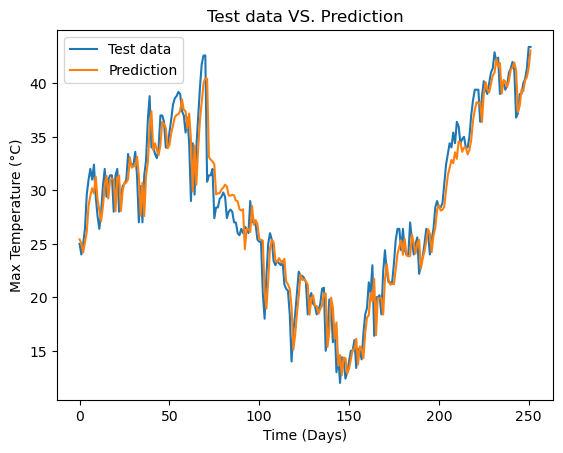

In [39]:
# Select the column to use as the y-coordinates
y = actual

# Draw the data points
plt.plot(actual, label= 'Test data')
plt.plot(final_prediction, label = 'Prediction')
plt.legend()
plt.xlabel("Time (Days)")
plt.ylabel("Max Temperature (°C)")
plt.title("Test data VS. Prediction")

# Show the plot
plt.show()

In [28]:
final_forcast

array([[42.26],
       [42.24],
       [42.29],
       [42.34],
       [42.4 ],
       [42.48],
       [42.56],
       [42.65],
       [42.74],
       [42.84],
       [42.94],
       [43.05],
       [43.15],
       [43.26]])

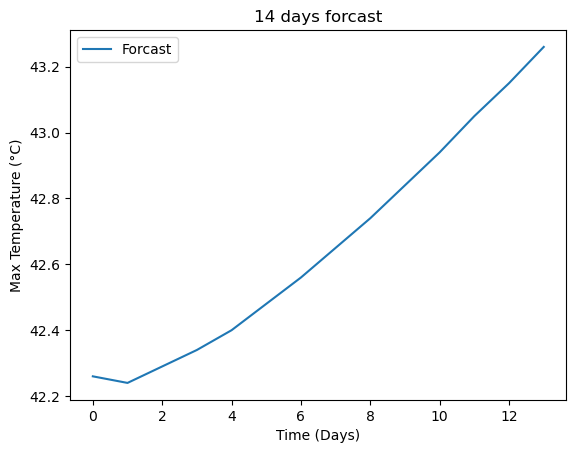

In [41]:
# Select the column to use as the y-coordinates
y = actual

# Draw the data points

plt.plot(final_forcast, label = 'Forcast')
plt.legend()
plt.xlabel("Time (Days)")
plt.ylabel("Max Temperature (°C)")
plt.title("14 days forcast")

# Show the plot
plt.show()

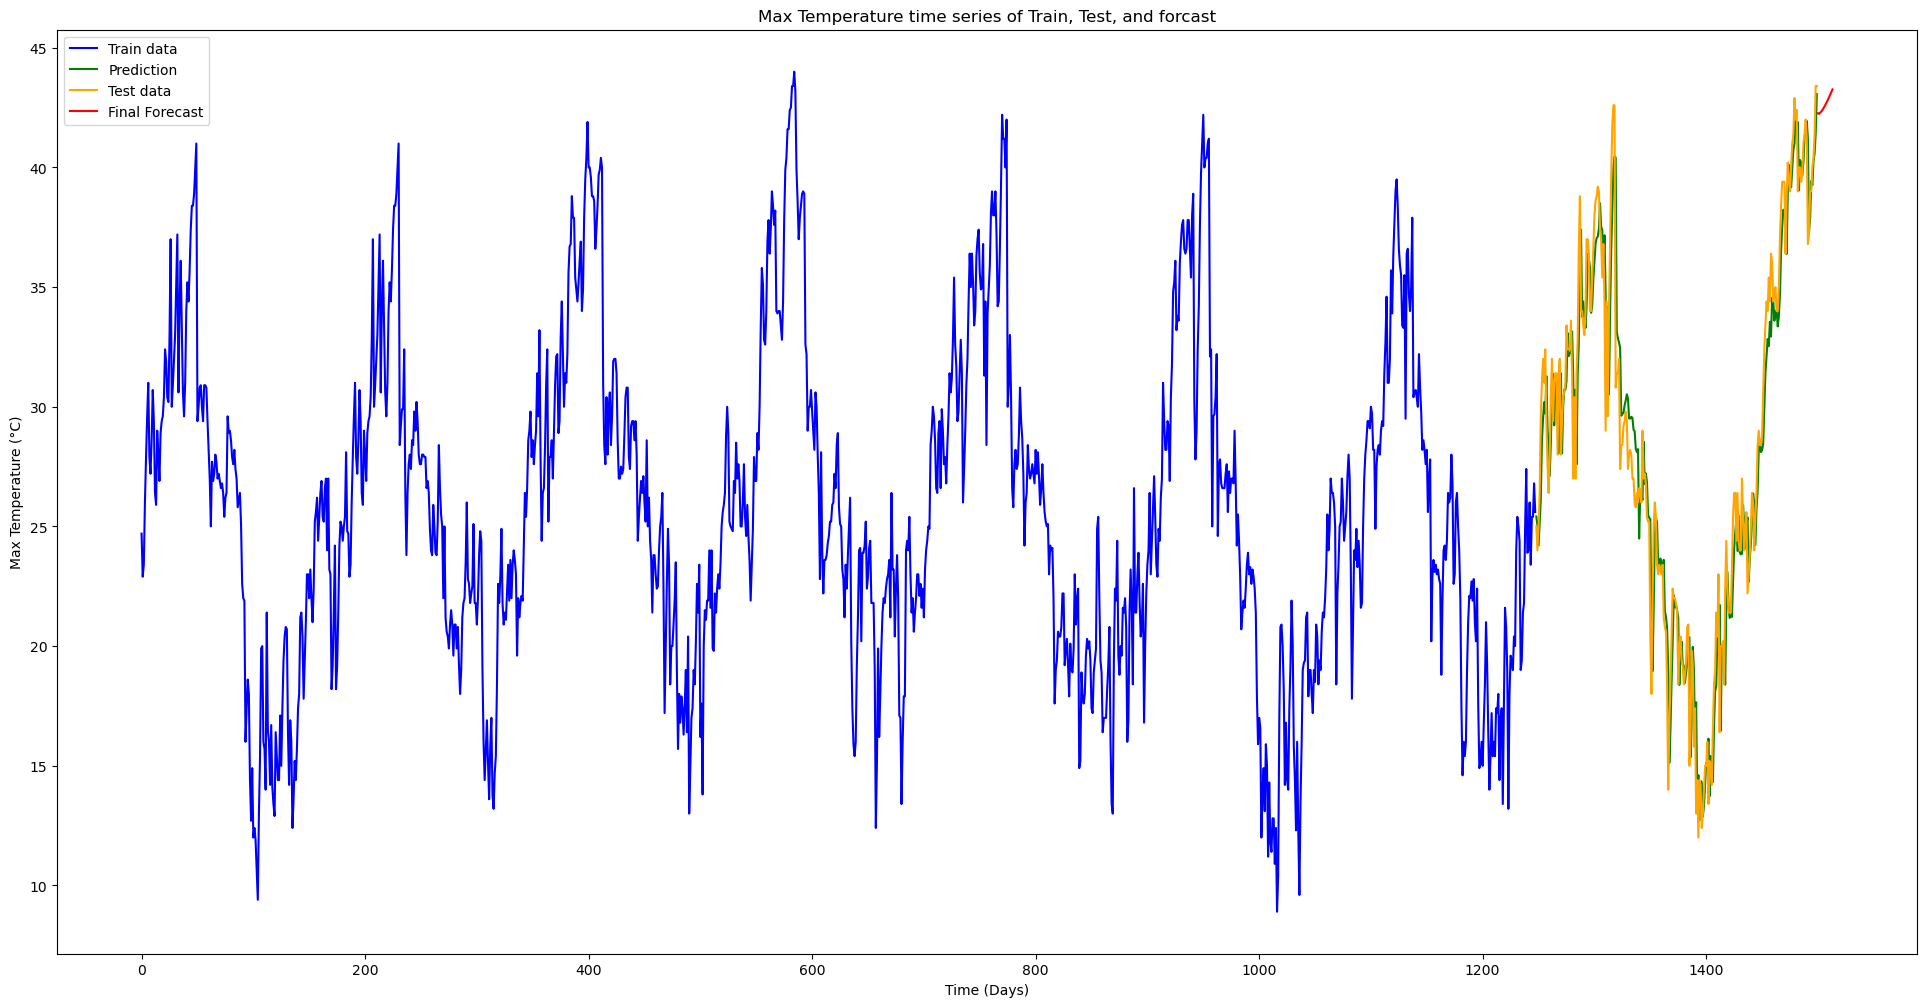

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# # Generate three arrays
# data = np.random.rand(50)
# final_prediction = np.random.rand(50)
# final_forecast = np.random.rand(50)

data1 = data[:-252]
# Create a step plot of the combined array with different colors
first_time_axis = range(len(data1))
second_time_axis = range(len(data1), len(data1)+len(final_prediction))
third_time_axis = range(len(data1)+len(final_prediction), len(data1)+len(final_prediction)+len(final_forcast))

fig = plt.figure(figsize= (24,12))
plt.plot(first_time_axis, data1, color='blue', label='Train data')
plt.plot(second_time_axis, final_prediction, color='green', label='Prediction')
plt.plot(second_time_axis, actual, color='orange', label='Test data')
plt.plot(third_time_axis, final_forcast, color='red', label='Final Forecast')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Time (Days)')
plt.ylabel('Max Temperature (°C)')
plt.title('Max Temperature time series of Train, Test, and forcast')

# Display the plot
plt.show()


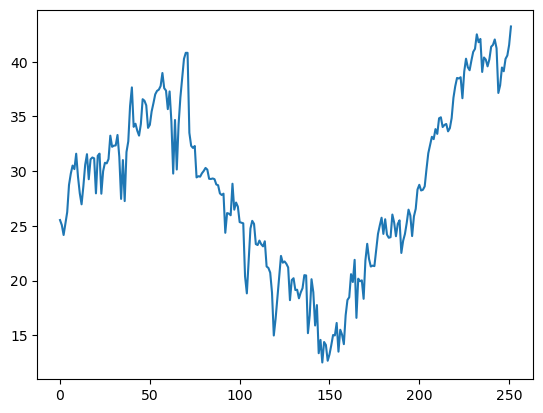

In [21]:
# Select the column to use as the y-coordinates
y = final_prediction

# Draw the data points
plt.plot(y)

# Show the plot
plt.show()